# Optimizer Comparison: SGD vs Adam on a Simple Binary Classification Problem

This notebook trains the **same neural network** on the **same 2D dataset**, but with two different optimizers:

- **SGD (Stochastic Gradient Descent)**
- **Adam**

The workflow:

1. Prepare the dataset (2D points with binary labels).
2. Define a neural network model.
3. Train the model twice: once with SGD, once with Adam.
4. Compare:
   - Final loss and accuracy
   - Training curves (loss & accuracy vs. epochs)
   - How many epochs each optimizer takes to reach 95% accuracy
   - Decision boundaries learned by each optimizer


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

print("TensorFlow:", tf.__version__)

TensorFlow: 2.19.0


## 1. Define the Dataset

We create a small dataset of 2D points.  
Each point has two features: `[X, Y]`, and a binary target label `y` (0 or 1).

In [2]:
X = np.array([
    [0.5 , 1.3 ],
    [1.25, 0.9 ],
    [2.  , 0.7 ],
    [2.75, 0.9 ],
    [3.5 , 1.25],
    [0.5 , 1.7 ],
    [1.25, 1.4 ],
    [2.  , 1.2 ],
    [2.75, 1.35],
    [3.5 , 1.7 ],
], dtype=float)

# Targets (0 / 1)
y = np.array([0, 0, 0, 0, 0, 1, 1, 1, 1, 1], dtype=float)

print("X shape:", X.shape, " y shape:", y.shape)

X shape: (10, 2)  y shape: (10,)


## 2. Utility Functions and Model Definition

We define:

- `reset_seeds(seed)`: to make results reproducible.
- `build_model()`: to create a simple neural network.
- `train_model(optimizer, epochs, seed)`: to train the model with a given optimizer.

In [3]:
def reset_seeds(seed=42):
    np.random.seed(seed)
    tf.random.set_seed(seed)

def build_model():
    model = keras.Sequential([
        layers.Input(shape=(2,)),
        layers.Dense(32, activation="relu"),
        layers.Dense(1, activation="sigmoid")
    ])
    return model


temp_model = build_model()
temp_model.summary()

def train_model(optimizer, epochs=200, seed=42):
    reset_seeds(seed)
    model = build_model()
    model.compile(
        optimizer=optimizer,
        loss="binary_crossentropy",
        metrics=["accuracy"]
    )
    history = model.fit(X, y, epochs=epochs, verbose=0)
    return model, history

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 32)             │            96 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 129 (516.00 B)

 Trainable params: 129 (516.00 B)

 Non-trainable params: 0 (0.00 B)

## 3. Train Models with SGD and Adam

We now train the same model architecture twice:

- Once with **SGD**
- Once with **Adam**

Both use the same learning rate and the same number of epochs for a fair comparison.

In [4]:
EPOCHS = 100

# SGD
model_sgd, history_sgd = train_model(
    keras.optimizers.SGD(learning_rate=0.05),
    epochs=EPOCHS,
    seed=42
)

# Adam
model_adam, history_adam = train_model(
    keras.optimizers.Adam(learning_rate=0.05),
    epochs=EPOCHS,
    seed=42
)

print("SGD  - final loss:",  history_sgd.history["loss"][-1],
      " final acc:", history_sgd.history["accuracy"][-1])
print("Adam - final loss:", history_adam.history["loss"][-1],
      " final acc:", history_adam.history["accuracy"][-1])

SGD  - final loss: 0.6073015928268433  final acc: 0.800000011920929
Adam - final loss: 0.003774140728637576  final acc: 1.0


## 4. Plot Training Loss and Accuracy

We visualize how loss and accuracy change over epochs for both optimizers.

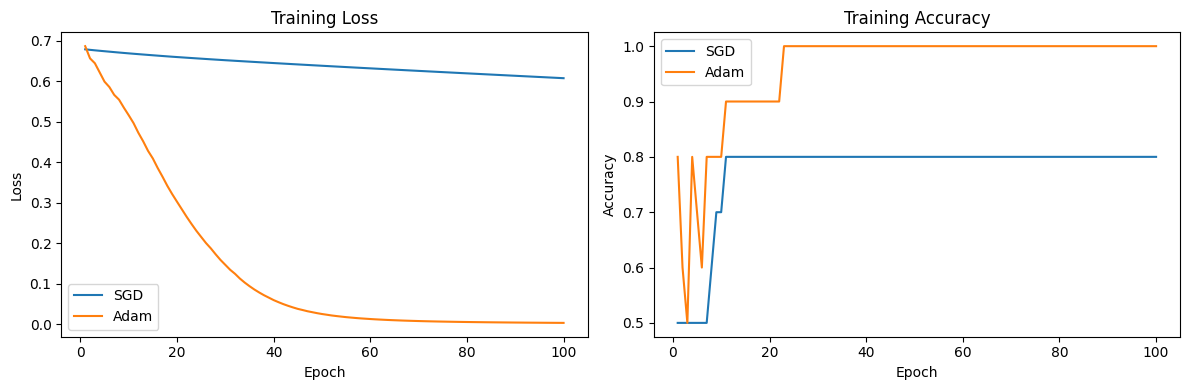

In [5]:
epochs_range = range(1, EPOCHS + 1)

plt.figure(figsize=(12, 4))

# Loss
plt.subplot(1, 2, 1)
plt.plot(epochs_range, history_sgd.history["loss"], label="SGD")
plt.plot(epochs_range, history_adam.history["loss"], label="Adam")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training Loss")
plt.legend()

# Accuracy
plt.subplot(1, 2, 2)
plt.plot(epochs_range, history_sgd.history["accuracy"], label="SGD")
plt.plot(epochs_range, history_adam.history["accuracy"], label="Adam")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Training Accuracy")
plt.legend()

plt.tight_layout()
plt.show()

## 5. How Many Epochs to Reach 95% Accuracy?

We define a helper to compute the first epoch where accuracy reaches a specified threshold (e.g., 95%).

In [6]:
def epochs_to_reach(history, metric, threshold):
    for i, val in enumerate(history.history[metric], start=1):
        if val >= threshold:
            return i
    return None

sgd_ep  = epochs_to_reach(history_sgd,  "accuracy", 0.95)
adam_ep = epochs_to_reach(history_adam, "accuracy", 0.95)

print("Epochs to reach 95% accuracy:")
print("  SGD :", sgd_ep)
print("  Adam:", adam_ep)

Epochs to reach 95% accuracy:
  SGD : None
  Adam: 23


## 6. Visualize Decision Boundaries

We now visualize the decision regions learned by each model.

- We create a grid of points across the feature space.
- We use the model to predict the class for each grid point.
- We color the regions and overlay the training samples on top.

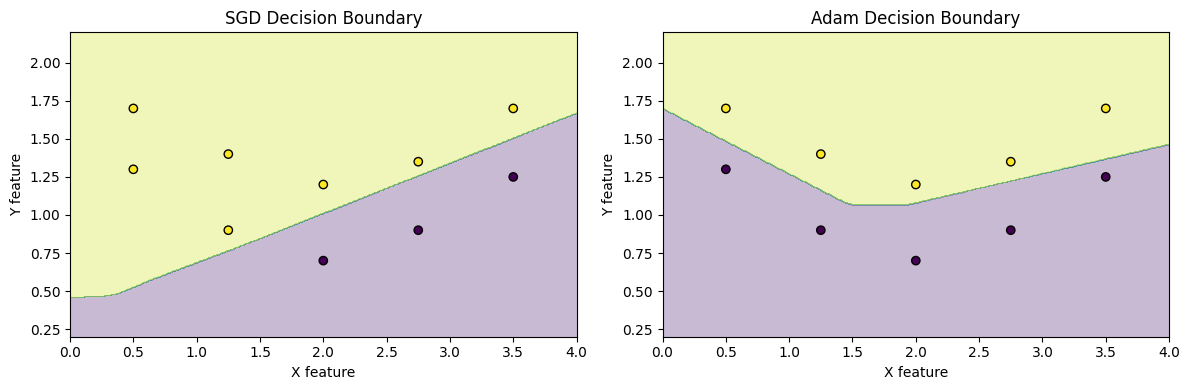

In [7]:
def decision_boundary_ax(model, X, ax, title):
    # Create grid
    x_min, x_max = X[:, 0].min() - 0.5, X[:, 0].max() + 0.5
    y_min, y_max = X[:, 1].min() - 0.5, X[:, 1].max() + 0.5

    xx, yy = np.meshgrid(
        np.linspace(x_min, x_max, 300),
        np.linspace(y_min, y_max, 300)
    )

    grid_points = np.c_[xx.ravel(), yy.ravel()]
    grid_pred = (model.predict(grid_points, verbose=0) >= 0.5).astype(int)
    Z = grid_pred.reshape(xx.shape)

    # Predictions on training points
    y_pred = (model.predict(X, verbose=0) >= 0.5).astype(int).reshape(-1)

    # Plot decision regions + points
    ax.contourf(xx, yy, Z, alpha=0.3)
    ax.scatter(X[:, 0], X[:, 1], c=y_pred, edgecolor="k")
    ax.set_title(title)
    ax.set_xlabel("X feature")
    ax.set_ylabel("Y feature")

fig, axes = plt.subplots(1, 2, figsize=(12, 4))

decision_boundary_ax(model_sgd,  X, axes[0], "SGD Decision Boundary")
decision_boundary_ax(model_adam, X, axes[1], "Adam Decision Boundary")

plt.tight_layout()
plt.show()